In [1]:
import torch
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0)
print(device)

width, height = 60, 80
pix_num = width * height


cuda:0


In [2]:


class Net(nn.Module):
    def __init__(self, H):
        super(Net, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(H, H//2), nn.ELU(),
            nn.Linear(H//2, H//2), nn.ELU(),
            nn.Linear(H//2, H//2), nn.ELU(),
            nn.Linear(H//2, H//2), nn.ELU(),
            nn.Linear(H//2, H//2), nn.ELU(),
            nn.Linear(H//2, H//2), nn.ELU(),
            nn.Linear(H//2, H//2), nn.ELU(),
            nn.Linear(H//2, H//2), nn.ELU(),
            nn.Linear(H//2, H//2), nn.ELU(),
            nn.Linear(H//2, H), nn.Sigmoid())
        
    def forward(self, x):
        x.to(device)
        y_pred = self.net(x.flatten())
        
        return y_pred.view(width, height)


In [3]:
from PIL import Image, ImageOps
import numpy as np

def get_grayscale_image_arr(path):
    im = ImageOps.grayscale(Image.open(path))
    image_array = np.array(im).astype(int)
    
    for x in range(im.size[1]):
        for y in range(im.size[0]):
            if image_array[x][y] != 255:
                image_array[x][y] = 0

    image_array = image_array.astype(bool).astype(int)
    return image_array


In [4]:
img_arr = get_grayscale_image_arr('./1st_test.bmp')
bound_length = len(np.where(img_arr == 0)[0])

In [5]:

# D_in рамерность входа; H скрытая размерность; D_out выход.
H, lr = pix_num, 1e-2

model = Net(H)
model.to(device)
model

Net(
  (net): Sequential(
    (0): Linear(in_features=4800, out_features=2400, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=2400, out_features=2400, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=2400, out_features=2400, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=2400, out_features=2400, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=2400, out_features=2400, bias=True)
    (9): ELU(alpha=1.0)
    (10): Linear(in_features=2400, out_features=2400, bias=True)
    (11): ELU(alpha=1.0)
    (12): Linear(in_features=2400, out_features=2400, bias=True)
    (13): ELU(alpha=1.0)
    (14): Linear(in_features=2400, out_features=2400, bias=True)
    (15): ELU(alpha=1.0)
    (16): Linear(in_features=2400, out_features=2400, bias=True)
    (17): ELU(alpha=1.0)
    (18): Linear(in_features=2400, out_features=4800, bias=True)
    (19): Sigmoid()
  )
)

In [6]:
def loss_fn(y):
    first_integral = y[np.where(img_arr > 0)].sum() / (pix_num - bound_length) # хочу НЕ границу единицами    4583 = количество НЕграничных пикселей
    #second_integral = y.abs().sum()
    bound_intgegral = 1 - y[np.where(img_arr == 0)].sum() / bound_length # хочу на границе нули
    return bound_intgegral ** 2 + first_integral.abs() ** 2

optimizer = torch.optim.SGD(model.parameters(), lr=lr)


In [11]:
net_input = torch.tensor([i for i in range(pix_num)]).float().view(width, height).requires_grad_().to(device)
for epoch in range(1000):
    ans = net_input
    optimizer.zero_grad() # обнулил градиенты
    y_pred = model(ans)# заполнил тензор числами
    
    loss = loss_fn(y_pred) # посчитал лосс
    print(f'Epoch {epoch}, loss: {loss.item()}')

    
    loss.backward() #обновил градиенты
    optimizer.step() #делаю шаг


Epoch 0, loss: 0.021379835903644562
Epoch 1, loss: 0.021379394456744194
Epoch 2, loss: 0.021378887817263603
Epoch 3, loss: 0.02137831598520279
Epoch 4, loss: 0.02137763984501362
Epoch 5, loss: 0.021376844495534897
Epoch 6, loss: 0.02137586660683155
Epoch 7, loss: 0.021374652162194252
Epoch 8, loss: 0.021373094990849495
Epoch 9, loss: 0.021371064707636833
Epoch 10, loss: 0.021368352696299553
Epoch 11, loss: 0.02136467769742012
Epoch 12, loss: 0.021359765902161598
Epoch 13, loss: 0.021353548392653465
Epoch 14, loss: 0.02134654112160206
Epoch 15, loss: 0.02133987843990326
Epoch 16, loss: 0.02133454568684101
Epoch 17, loss: 0.021330714225769043
Epoch 18, loss: 0.021328043192625046
Epoch 19, loss: 0.02132614701986313
Epoch 20, loss: 0.021324750036001205
Epoch 21, loss: 0.021323690190911293
Epoch 22, loss: 0.02132284827530384
Epoch 23, loss: 0.02132216840982437
Epoch 24, loss: 0.021321598440408707
Epoch 25, loss: 0.021321114152669907
Epoch 26, loss: 0.021320700645446777
Epoch 27, loss: 0.021

In [12]:
y_pred_new = y_pred  * 225.
y_pred_new

tensor([[3.2924e-03, 3.6958e-02, 3.5077e-03,  ..., 1.4217e-04, 2.2136e-03,
         3.4814e-02],
        [2.8775e-04, 6.6032e-09, 4.8673e-03,  ..., 6.8869e-04, 2.2020e-03,
         4.0116e-02],
        [1.4268e-08, 5.7532e-02, 3.7510e-03,  ..., 2.3100e-02, 1.2572e-02,
         2.2500e+02],
        ...,
        [2.2500e+02, 6.7363e-02, 1.7606e-03,  ..., 2.3885e-04, 2.2500e+02,
         1.2500e-04],
        [8.3157e-04, 2.5315e-06, 3.5408e-04,  ..., 5.3614e-06, 3.6185e-02,
         1.4456e-02],
        [4.2410e-02, 1.9818e-02, 2.2500e+02,  ..., 4.8295e-10, 9.9126e-04,
         7.1901e-02]], device='cuda:0', grad_fn=<MulBackward0>)

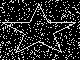

In [13]:
from PIL import Image
Image.fromarray(y_pred_new.cpu().detach().numpy().astype('uint8'))

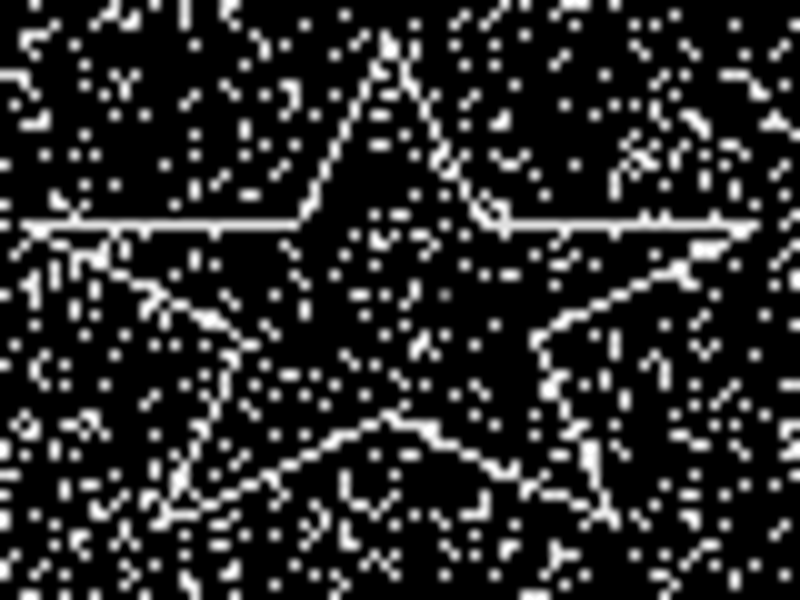

In [14]:
Image.fromarray(y_pred_new.cpu().detach().numpy().astype('uint8')).resize((800, 600))